In [25]:
import numpy as np
import pandas as pd
from sklearn.linear_model import ElasticNetCV
from sklearn.model_selection import TimeSeriesSplit
from scipy.stats import spearmanr

In [7]:
train = pd.read_csv("train.csv", parse_dates=["date"])
test  = pd.read_csv("test.csv", parse_dates=["date"])

In [43]:
#---- let's just chosse the largest 500 comapnies for simplification

df = train.copy()
df_top500 = (
    df.sort_values(["date", "Mkt_Cap_12M_Usd"], ascending=[True, False])
      .groupby("date")
      .head(500)   # take top 500 rows within each group
      .reset_index(drop=True)
)

print("Original shape:", df.shape)
print("Filtered shape:", df_top500.shape)

# Use a manually selected smaller feature subset 
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", 
                  "Ocf", "Pb", "Vol1Y_Usd"]
features = df_top500.columns[2:95].tolist()

Original shape: (198128, 99)
Filtered shape: (84000, 99)


In [11]:
# Ensure types
df_top500["stock_id"] = df_top500["stock_id"].astype(str)

# Get sorted unique monthly dates in training set
dates = sorted(df_top500["date"].unique())
# Containers for outputs
pred_rows = []         # per-stock per-month predictions & standardized scores
active_feat_rows = []  # per-month list of features with non-zero coefficients
ic_rows = []           # monthly IC for quick sanity check

In [17]:
# 1) ENet：avoid mulicollinearity 
L1_GRID = [0.6, 0.8, 1.0]  # l1_ratio
ALPHA_GRID = np.logspace(-4, 1, 30) 
N_FOLDS = 5
LOOKBACK_MONTHS = 36
MIN_STOCKS = 100

In [19]:
def to_f32(a): 
    return np.asarray(a, dtype=np.float32)

pred_rows, ic_rows, active_feat_rows = [], [], []

# 3) z-score function
def cross_sectional_clean(df, feature_cols):
    out = df.copy()
    # —— 月内 z-score
    def _z(x):
        m, s = x.mean(), x.std(ddof=0)
        if s <= 0 or np.isfinite(s) is False:
            return np.zeros_like(x)
        return (x - m) / s
    out[feature_cols] = out.groupby('date')[feature_cols].transform(_z)

    return out


# df_top500 including ['date','stock_id','R1M_Usd'] + features_short 
dates = sorted(df_top500['date'].unique())


In [47]:
for i in range(LOOKBACK_MONTHS, len(dates)):
    t = dates[i]  
    window_dates = dates[i - LOOKBACK_MONTHS : i]  

    train_win_raw = df_top500[df_top500["date"].isin(window_dates)]
    if train_win_raw.empty:
        continue

    train_win = cross_sectional_clean(train_win_raw, features)

    X_tr = to_f32(train_win[features].values)
    y_tr = to_f32(train_win["R1M_Usd"].values)

    
    month_to_idx = {d: train_win.index[train_win['date'] == d].values for d in window_dates}
    
    tscv = TimeSeriesSplit(n_splits=N_FOLDS)

    best_model, best_mse, best_l1, best_alpha = None, np.inf, None, None
    for l1 in L1_GRID:
        enet_cv = ElasticNetCV(
            l1_ratio=l1,
            alphas=ALPHA_GRID,
            cv=tscv,
            max_iter=5000,
            n_jobs=-1,
            random_state=42
        )
        enet_cv.fit(X_tr, y_tr)
        # ElasticNetCV 的 mse_path_ 形状为 (n_alphas, n_folds)
        mse = np.mean(enet_cv.mse_path_.mean(axis=1))
        if mse < best_mse:
            best_mse = mse
            best_model = enet_cv
            best_l1 = l1
            best_alpha = float(enet_cv.alpha_)

   
    coef_s = pd.Series(best_model.coef_, index=features)
    active_feats = coef_s[coef_s.abs() > 1e-12].index.tolist()
    active_feat_rows.append({
        "date": pd.to_datetime(t),
        "n_active": len(active_feats),
        "l1_ratio": best_l1,
        "alpha": best_alpha,
        "active_features": ",".join(active_feats)
    })

   
    te_raw = df_top500[df_top500["date"] == t].copy()
    if len(te_raw) < MIN_STOCKS:
        continue

    te = cross_sectional_clean(te_raw, features)

    X_te = to_f32(te[features].values)
    mu_hat = best_model.predict(X_te).astype(np.float32)  

    mu_mean, mu_std = float(mu_hat.mean()), float(mu_hat.std())
    if not np.isfinite(mu_std) or mu_std <= 0:
        z = np.zeros_like(mu_hat, dtype=np.float32)
    else:
        z = (mu_hat - mu_mean) / mu_std

    tmp = te[["date", "stock_id", "R1M_Usd"]].copy()
    tmp["mu_hat_lasso"] = mu_hat
    tmp["score_lasso"] = z
    pred_rows.append(tmp)

    try:
        ic = spearmanr(z, te["R1M_Usd"].values, nan_policy="omit").correlation
    except Exception:
        ic = np.nan
    ic_rows.append({"date": pd.to_datetime(t), "IC_lasso": ic})

C:\Users\xvlin\AppData\Local\Temp\ipykernel_1496\3226404235.py:84: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(z, te["R1M_Usd"].values, nan_policy="omit").correlation
C:\Users\xvlin\AppData\Local\Temp\ipykernel_1496\3226404235.py:84: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(z, te["R1M_Usd"].values, nan_policy="omit").correlation
C:\Users\xvlin\AppData\Local\Temp\ipykernel_1496\3226404235.py:84: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(z, te["R1M_Usd"].values, nan_policy="omit").correlation
C:\Users\xvlin\AppData\Local\Temp\ipykernel_1496\3226404235.py:84: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  ic = spearmanr(z, te["R1M_Usd"].values, nan_policy="omit").correlation
C:\Users\xvlin\anaconda3\Lib\site-packages\sklearn\linear_model\

In [49]:
pred_df = pd.concat(pred_rows, ignore_index=True)

In [51]:
pred_df

,date,stock_id,R1M_Usd,mu_hat_lasso,score_lasso
0,2003-01-31,331,0.049,-0.003518,-0.771084
1,2003-01-31,414,-0.513,-0.008324,-1.469244
2,2003-01-31,435,-0.002,-0.006772,-1.243880
3,2003-01-31,436,-0.025,-0.008610,-1.510806
4,2003-01-31,522,-0.021,-0.011184,-1.884837
...,...,...,...,...,...
131995,2013-12-31,1183,0.078,0.012366,0.000000
131996,2013-12-31,31,-0.006,0.012366,0.000000
131997,2013-12-31,243,0.059,0.012366,0.000000
131998,2013-12-31,397,0.054,0.012366,0.000000


In [57]:
ic_df = pd.DataFrame(ic_rows)

In [59]:
ic_df

,date,IC_lasso
0,2003-01-31,-0.043256
1,2003-02-28,-0.114728
2,2003-03-31,NaN
3,2003-04-30,0.212860
4,2003-05-31,NaN
...,...,...
259,2013-08-31,NaN
260,2013-09-30,NaN
261,2013-10-31,NaN
262,2013-11-30,NaN


In [53]:
active_df = pd.DataFrame(active_feat_rows)

In [69]:
# 1) Drop NaN ICs
ic_df_clean = ic_df.dropna(subset=["IC_lasso"]).reset_index(drop=True)

# 2) Drop months with no active features
active_df_clean = active_df.copy()
active_df_clean["n_active"] = active_df_clean["n_active"].fillna(0).astype(int)
active_df_clean = active_df_clean[active_df_clean["n_active"] > 0].reset_index(drop=True)

# 3) Keep pred_df only for valid months
valid_months = set(ic_df_clean["date"]) & set(active_df_clean["date"])
pred_df_clean = pred_df[pred_df["date"].isin(valid_months)].reset_index(drop=True)


In [71]:
pred_df_clean 

,date,stock_id,R1M_Usd,mu_hat_lasso,score_lasso
0,2003-01-31,331,0.049,-0.003518,-0.771084
1,2003-01-31,414,-0.513,-0.008324,-1.469244
2,2003-01-31,435,-0.002,-0.006772,-1.243880
3,2003-01-31,436,-0.025,-0.008610,-1.510806
4,2003-01-31,522,-0.021,-0.011184,-1.884837
...,...,...,...,...,...
41995,2010-12-31,1008,-0.243,0.004877,-1.000000
41996,2010-12-31,1070,-0.038,0.004877,-1.000000
41997,2010-12-31,1193,-0.064,0.004877,-1.000000
41998,2010-12-31,196,0.032,0.004877,-1.000000


In [73]:
active_df_clean

,date,n_active,l1_ratio,alpha,active_features
0,2003-01-31,6,0.6,0.003562,"Div_Yld,Mkt_Cap_12M_Usd,Mom_11M_Usd,Ocf,Pb,Vol..."
1,2003-01-31,6,0.6,0.003562,"Div_Yld,Mkt_Cap_12M_Usd,Mom_11M_Usd,Ocf,Pb,Vol..."
2,2003-02-28,6,0.6,0.005298,"Div_Yld,Mkt_Cap_12M_Usd,Mom_11M_Usd,Ocf,Pb,Vol..."
3,2003-04-30,1,1.0,0.007880,Pb
4,2004-05-31,2,1.0,0.003562,"Mkt_Cap_12M_Usd,Pb"
...,...,...,...,...,...
63,2007-06-30,15,1.0,0.001083,"Bb_Yld,Cash_Per_Share,Div_Yld,Ebit_Ta,Ev,Ev_Eb..."
64,2007-07-31,12,1.0,0.001610,"Cash_Per_Share,Div_Yld,Ebit_Ta,Ev_Ebitda,Fcf_T..."
65,2008-04-30,1,1.0,0.003562,Vol3Y_Usd
66,2009-10-31,1,1.0,0.005298,Mom_11M_Usd


In [75]:
ic_df_clean

,date,IC_lasso
0,2003-01-31,-0.043256
1,2003-02-28,-0.114728
2,2003-04-30,0.212860
3,2004-05-31,0.085557
4,2005-05-31,0.116413
...,...,...
61,2007-06-30,-0.120691
62,2007-07-31,-0.072826
63,2008-04-30,0.168806
64,2009-10-31,0.055735


IC Summary:
                  value
n_months     66.000000
IC_mean       0.021079
IC_std        0.120599
ICIR_12m      0.605465
IC_pos_rate   0.606061

Long-Short (Q10-Q1) Summary:
                   value
n_months      42.000000
mean_m         0.010658
std_m          0.036065
IR_ann         1.023702
hit_ratio      0.595238
cum_return     0.521539
max_drawdown  -0.143976


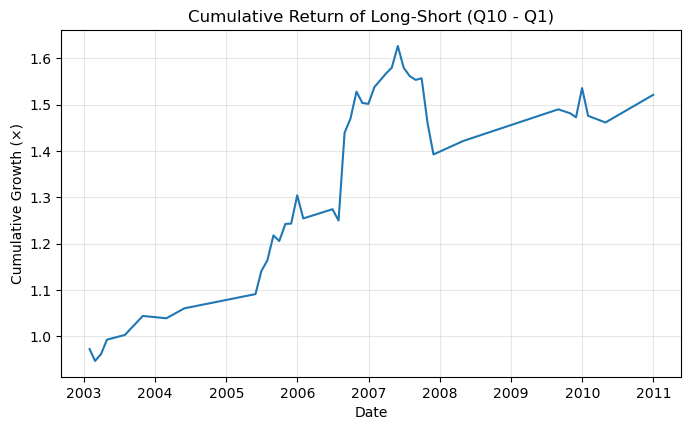


Top selected features:
                            feature  count
0                               Pb     49
1                        Vol1Y_Usd     45
2                      Mom_11M_Usd     44
3                          Div_Yld     30
4                              Eps     27
5                  Mkt_Cap_12M_Usd     23
6                   Mkt_Cap_3M_Usd     10
7                Mom_Sharp_11M_Usd      9
8   Recurring_Earning_Total_Assets      9
9                       Mom_5M_Usd      9
10                             Ocf      9
11                         Ptx_Mgn      8
12                       Ev_Ebitda      8
13                         Ebit_Ta      8
14                     Advt_3M_Usd      6
15                         Fcf_Yld      5
16                          Ocf_Ce      5
17                  Cash_Per_Share      5
18                      Free_Ps_Cf      5
19                 Tev_Less_Mktcap      5


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

# ---------------------------
# 0) Safety checks & casting
# ---------------------------
for _df in ["pred_df_clean", "ic_df_clean", "active_df_clean"]:
    if _df not in globals():
        raise ValueError(f"Missing {_df}. Please run the cleaning step first.")
    globals()[_df]["date"] = pd.to_datetime(globals()[_df]["date"])

# ---------------------------
# 1) IC summary
# ---------------------------
def ic_summary(ic_df):
    ic = ic_df["IC_lasso"].dropna().astype(float)
    out = {}
    if len(ic) == 0:
        out = {"n_months": 0, "IC_mean": np.nan, "IC_std": np.nan, "ICIR_12m": np.nan, "IC_pos_rate": np.nan}
    else:
        ic_mean = ic.mean()
        ic_std  = ic.std(ddof=1)
        icir_12 = (ic_mean / ic_std) * np.sqrt(12) if ic_std > 0 else np.nan
        out = {
            "n_months": int(len(ic)),
            "IC_mean": float(ic_mean),
            "IC_std": float(ic_std),
            "ICIR_12m": float(icir_12),
            "IC_pos_rate": float((ic > 0).mean())
        }
    return pd.Series(out)

ic_stats = ic_summary(ic_df_clean)
print("IC Summary:\n", ic_stats.to_frame(name="value"))

# ---------------------------
# 2) Quantile long-short backtest (Q10 - Q1)
# ---------------------------
def quantile_ls_returns(pred_df, q=10, score_col="score_lasso", ret_col="R1M_Usd"):
    rows = []
    for d, g in pred_df.groupby("date"):
        g = g[[score_col, ret_col]].dropna().copy()
        if len(g) < q * 
            continue

        g["__bin"] = pd.qcut(g[score_col].rank(method="first"), q, labels=False, duplicates="drop")
        if g["__bin"].max() < q-1:
            continue
        long = g.loc[g["__bin"] == q-1, ret_col].mean()
        short = g.loc[g["__bin"] == 0, ret_col].mean()
        rows.append({"date": d, "ls_return": long - short})
    return pd.DataFrame(rows).sort_values("date")

ls = quantile_ls_returns(pred_df_clean, q=10)

# Performance stats (monthly → annualized)
def perf_summary(ls_df, col="ls_return"):
    r = ls_df[col].dropna().astype(float)
    if len(r) == 0:
        return pd.Series({"n_months": 0, "mean_m": np.nan, "std_m": np.nan,
                          "IR_ann": np.nan, "hit_ratio": np.nan,
                          "cum_return": np.nan, "max_drawdown": np.nan})
    mean_m = r.mean()
    std_m  = r.std(ddof=1)
    ir_ann = (mean_m / std_m) * np.sqrt(12) if std_m > 0 else np.nan
    hit_ratio = (r > 0).mean()

    # cumulative & drawdown
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = (cum / peak) - 1.0
    max_dd = dd.min()

    return pd.Series({
        "n_months": int(len(r)),
        "mean_m": float(mean_m),
        "std_m": float(std_m),
        "IR_ann": float(ir_ann),
        "hit_ratio": float(hit_ratio),
        "cum_return": float(cum.iloc[-1] - 1.0),
        "max_drawdown": float(max_dd)
    })

ls_stats = perf_summary(ls, "ls_return")
print("\nLong-Short (Q10-Q1) Summary:\n", ls_stats.to_frame(name="value"))

# Plot cumulative curve (one chart, no custom colors)
if not ls.empty:
    cum = (1 + ls.set_index("date")["ls_return"].astype(float)).cumprod()
    plt.figure(figsize=(8, 4.5))
    plt.plot(cum.index, cum.values)
    plt.title("Cumulative Return of Long-Short (Q10 - Q1)")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Growth (×)")
    plt.grid(True, alpha=0.3)
    plt.show()

# ---------------------------
# 3) Feature stability (selection frequency)
# ---------------------------
def feature_frequency(active_df):
    # Merge all feature strings and count frequency
    feats = active_df["active_features"].dropna().astype(str)
    if feats.empty:
        return pd.DataFrame(columns=["feature", "count"])
    tokens = []
    for s in feats:
        s = s.strip()
        if not s:
            continue
        tokens.extend([t for t in s.split(",") if t.strip()])
    cnt = Counter(tokens)
    freq_df = pd.DataFrame(cnt.items(), columns=["feature", "count"]).sort_values("count", ascending=False)
    return freq_df.reset_index(drop=True)

freq_df = feature_frequency(active_df_clean)
print("\nTop selected features:\n", freq_df.head(20))

# ---------------------------
# 4) (Optional) Save outputs
# ---------------------------
# ls.to_csv("ls_monthly_returns.csv", index=False)
# freq_df.to_csv("active_feature_frequency.csv", index=False)
